# Universe Machine mass functions

* SMF of the new UM when considering in-situ, ex-situ, and the sum of both compared to Songs SMF
* look at the scatter in M* and Mhalo
- for in-situ
- for in-situ + ex-situ
- for N most massive galaxies

TODO:
* Once things are restructured get this ready for PR
* Cleanup figures
    * Consistent labels
    * Large labels everywhere
    * consider adding contours? Might be interesting
    * No titles
* SMF with new data (get from songs repo)
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Don't plot scatter of sm/hm ratio. Plot it of SM (because we are already at fixed hm)
    * Actually I am not sure. This seems like it will introduce error because of bin width?
    * Maybe I should always be plotting the ratio
    * I think I should always be plotting the ratio
    * See next point
* Take our plot of M_halo vs M_star and
    * make it a shaded plot rather than the pointy plot that it is
    * cut it at mhalo = 13
    * fit the mean using a formula given in Alexie's paper https://arxiv.org/pdf/1103.2077.pdf and https://files.slack.com/files-pri/T5WPLGLAF-F8QCPD9SL/image.png
    * Then when plotting scatter, plot scatter as X - expected(X) where expected comes from the fit.
    * This should remove the binning effect.
* half_mass_scale_a is probbaly for the dark matter this is now OK
* https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
* In the line plot 
    * cbx make this a 2 panel figure
    * use current halo mass
    * truncate at 13
* For centrals we should not use peak halo mass. That is not observable. Use current. This doesn't run into the issues that come with satellites (stripping) because we only care about centrals.

# Install and load data

In [154]:
%matplotlib inline
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Local libs
import sys
sys.path.append("..")

import plots
import cluster_sum
import lib.stellar_mass_function as smf
from importlib import reload # for when I mess up local libs

In [300]:
datadir = os.getenv("dataDir") + "/universe_machine/"
catalog_file = "sfr_catalog_insitu_exsitu_0.712400_final_extended.npz"

catalog = np.load(datadir + catalog_file)
centrals = catalog["centrals"]
satellites = catalog["satellites"]
centrals_gt_13 = centrals[centrals["m"] > 1e13]


# Our data

Let's get a very broad sense of our data

In [4]:
print(centrals.dtype)
print(len(centrals))
print(len(satellites))
print(satellites[:10])
print(centrals[centrals['id'] == 8272347969])

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]
385125
10809469
[ (8272347655, 8272347654,  13.83487,  18.749399,  16.14661 ,   1.98400000e+09,   3.11700000e+09,   2.31400000e+05,   0.00000000e+00,   6.41000000e-05,   1.34880000e+09,  25.014   ,  1.248,  0.281 ,  0.281 ,   1.34880000e+09,   1.34880000e+09,  0.    ,  0.     , -0.1056,  -0.1456,  0.    ,   30.41)
 (8272348262, 8272347732,  15.026  ,  17.7521  ,  17.388531,   1.98400000e+09,   2.26700000e+09,   1.15200000e+03,   0.00000000e+00,   2.51000000e-06,   1.34880000e+09,  25.014   ,  2.777,  0.6884,  0.6884,   1.34880000e+09,   1.252

385117 centrals without ICL of our 385125 samples


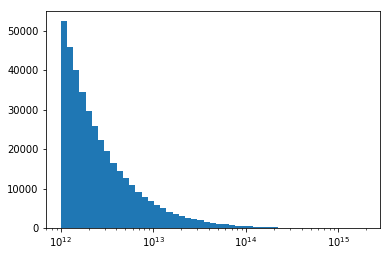

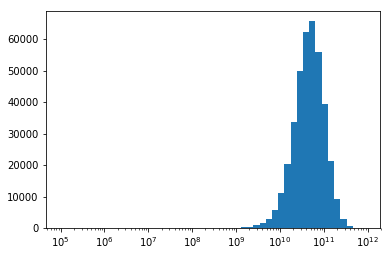

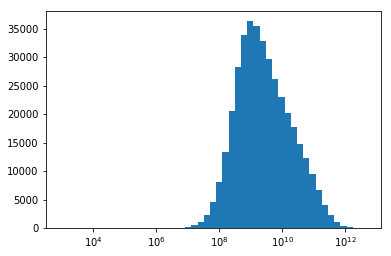

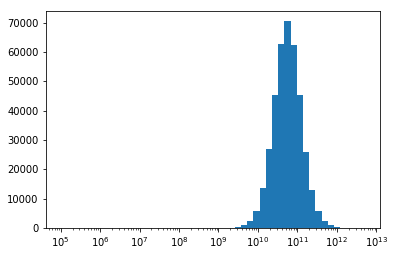

In [5]:
fig, ax = plt.subplots()
_ = ax.hist(centrals["mp"], bins = np.geomspace(np.amin(centrals["mp"]), np.amax(centrals["mp"]), 50))
_ = ax.set(xscale="log")

fig, ax = plt.subplots()
_ = ax.hist(centrals["sm"], bins = np.geomspace(np.amin(centrals["sm"]), np.amax(centrals["sm"]), 50))
_ = ax.set(xscale="log")

fcentrals = centrals[np.nonzero(centrals["icl"])[0]]
fig, ax = plt.subplots()
_ = ax.hist(fcentrals["icl"], bins = np.geomspace(np.amin(fcentrals["icl"]), np.amax(fcentrals["icl"]), 50))
_ = ax.set(xscale="log")
print(
    "{} centrals without ICL of our {} samples".format(len(np.nonzero(centrals["icl"])[0]), len(centrals))
)

fig, ax = plt.subplots()
_ = ax.hist(
    centrals["icl"] + centrals["sm"],
    bins = np.geomspace(
        np.amin(centrals["icl"]) + np.amin(centrals["sm"]),
        np.amax(centrals["icl"]) + np.amax(centrals["sm"]),
        50))
_ = ax.set(xscale="log")

# SMHM relations

Now let's plot the SM, halo mass relations for centrals

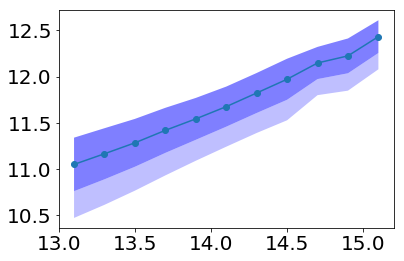

In [311]:
reload(plots)
plots.dm_vs_sm(centrals_gt_13)

# SMHM ratio scatter for clusters

What happens if we start to plot this relation for multiple members of the cluster?

In [3]:
reload(cluster_sum)
data = {
    0: centrals,
    1: cluster_sum.centrals_with_satellites(centrals, satellites, 1),
    2: cluster_sum.centrals_with_satellites(centrals, satellites, 2),
    5: cluster_sum.centrals_with_satellites(centrals, satellites, 5),
    9: cluster_sum.centrals_with_satellites(centrals, satellites, 9),
    "all": cluster_sum.centrals_with_satellites(centrals, satellites, 0.9999),
}
# cbx do above figure with shaded not points
# look in old alexie/peter paper to get functional form for M* Mhalo and fit them.

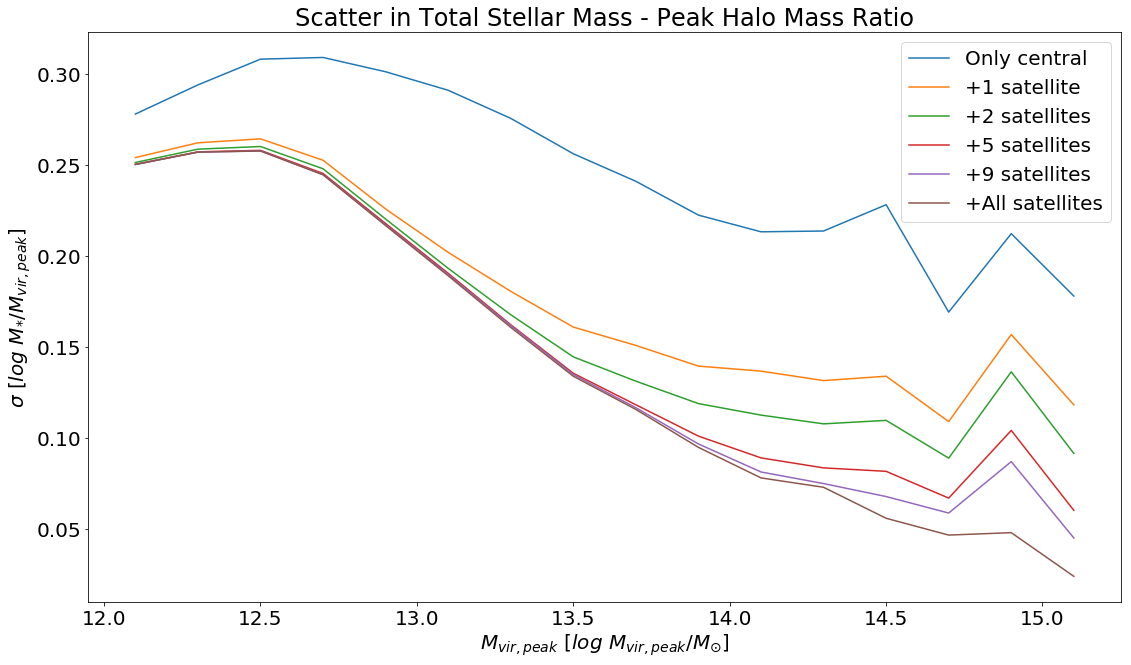

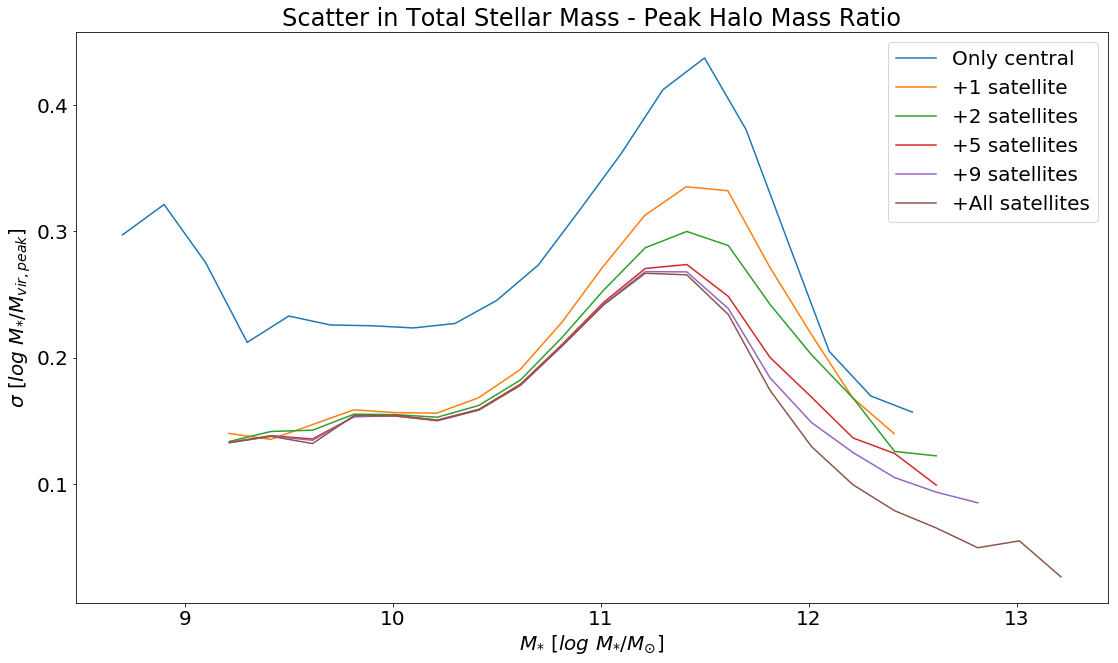

In [199]:
reload(plots)
matplotlib.rcParams.update({'font.size': 20})
plots.dm_vs_all_sm_error(
    [data[0], data[1], data[2], data[5], data[9], data["all"]],
    "hm",
    labels = ["Only central", "+1 satellite", "+2 satellites", "+5 satellites", "+9 satellites", "+All satellites"],
)
plots.dm_vs_all_sm_error(
    [data[0], data[1], data[2], data[5], data[9], data["all"]],
    "sm",
    labels = ["Only central", "+1 satellite", "+2 satellites", "+5 satellites", "+9 satellites", "+All satellites"],
)
# cbx make this a 2 panel figure
# use current halo mass
# truncate at 13
# add figure y: Mhalo x: M* (halo > 13)

# SMF

What does our SMF look like? 

In [202]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [203]:
print(m10_smf.dtype)
print(m10_smf)

(numpy.record, [('logm_mean', '>f8'), ('logm_0', '>f8'), ('logm_1', '>f8'), ('smf', '>f8'), ('smf_err', '>f8'), ('smf_low', '>f8'), ('smf_upp', '>f8')])
[ ( 10.45,  10.4,  10.5,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.55,  10.5,  10.6,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.65,  10.6,  10.7,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.75,  10.7,  10.8,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.85,  10.8,  10.9,   1.23958176e-07,   2.48352780e-08,  -2.47916352e-08,   2.72707987e-07)
 ( 10.95,  10.9,  11. ,   2.47916352e-07,   4.96449906e-08,   7.43749056e-08,   4.21457798e-07)
 ( 11.05,  11. ,  11.1,   4.95832704e-07,   9.92538264e-08,   1.48749811e-07,   8.42915597e-07)
 ( 11.15,  11.1,  11.2,   6.44582515e-06,   1.28947974e-06,   4.28895289e-06,   8.60269741e-06)
 ( 11.25,  11.2,  11.3,   3.94187000e-05,   7.88451825e-06,   2.95516291e-05, 

Dropped 0 galaxies with mass of 0
Dropped 0 galaxies with mass of 0
Dropped 4 galaxies with mass of 0


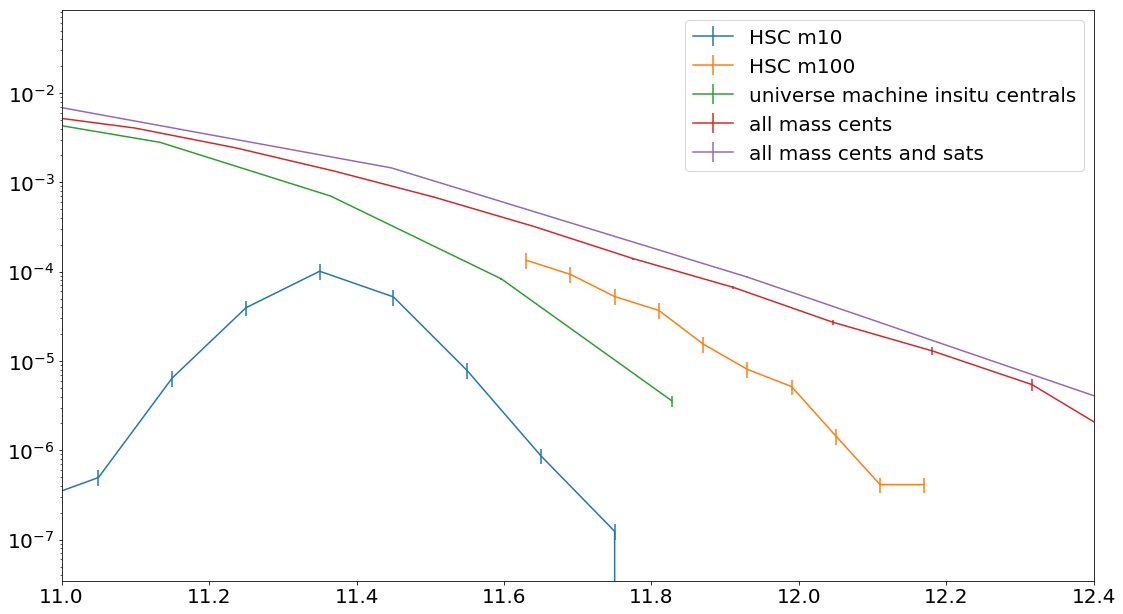

In [210]:
reload(smf)

def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness

What about richness? Does that have a relation with scatter at fixed halo mass

In [213]:
reload(cluster_sum)
minMassForRichness = 10**10.8 # min mass for a sat to count towards richness

richness = cluster_sum.get_richness(centrals, satellites, minMassForRichness)

In [221]:
richCentrals = centrals[richness != 0]
print(len(centrals), len(richCentrals))
smallestHaloWithRichness = np.min(richCentrals["mp"])
print(smallestHaloWithRichness)

385125 35794
1.04e+12



At fixed halo mass, richer clusters tend to have slightly more SMHM variance. But this is weak...



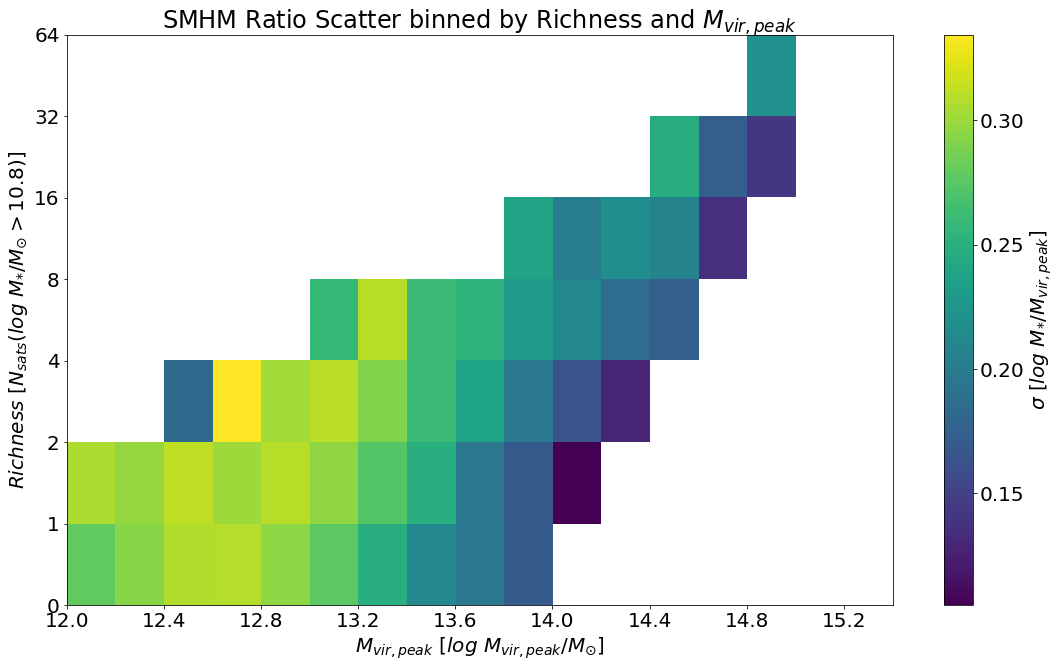

In [263]:
reload(plots)

plots.richness_vs_scatter(
    centrals[centrals["mp"] > smallestHaloWithRichness],
    satellites,
    minMassForRichness)
print("""
At fixed halo mass, richer clusters tend to have slightly more SMHM variance. But this is weak...
""")

# Concentration

Same as richness but for concentration

Just centrals
Total SM (including all sats)


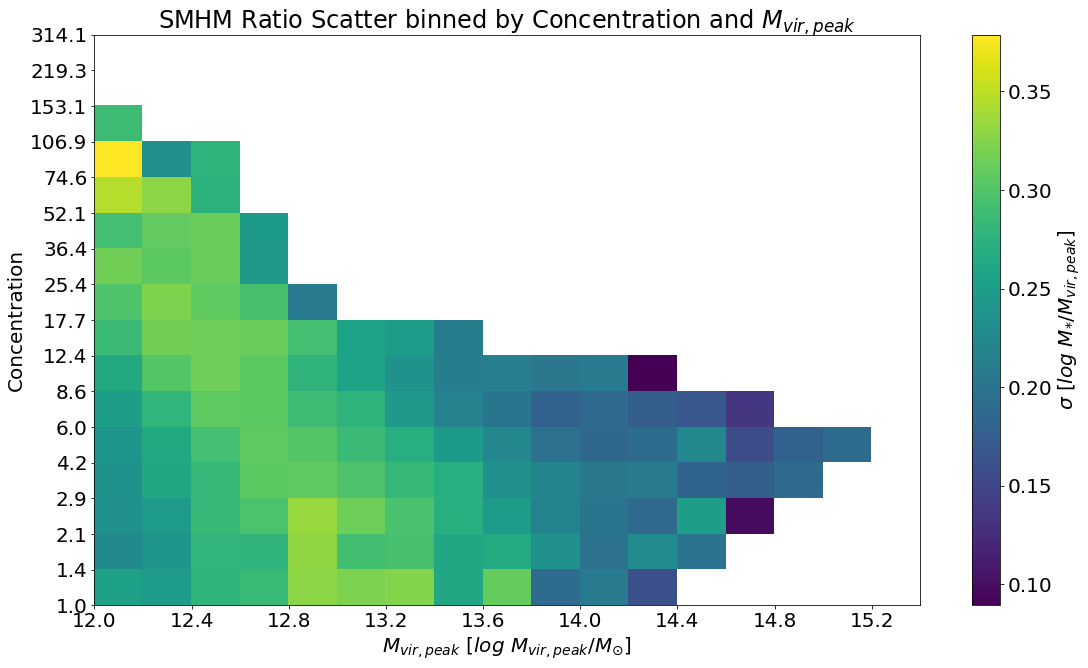

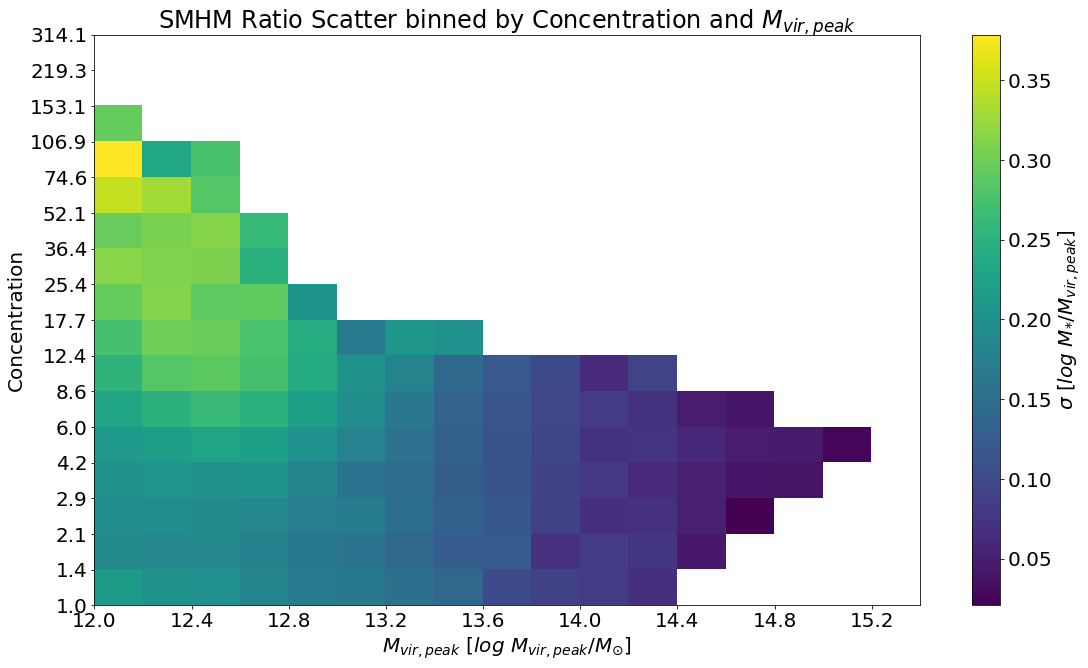

In [283]:
reload(plots)
# should probably have the centrals vs all in the title not just printed...
print("Just centrals")
plots.concentration_vs_scatter(centrals)
print("Total SM (including all sats)")
plots.concentration_vs_scatter(data["all"])

# Age

What about age?

In [285]:
print(centrals.dtype) # no obvious halfmass stellar scale

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]


Just centrals
All galacies


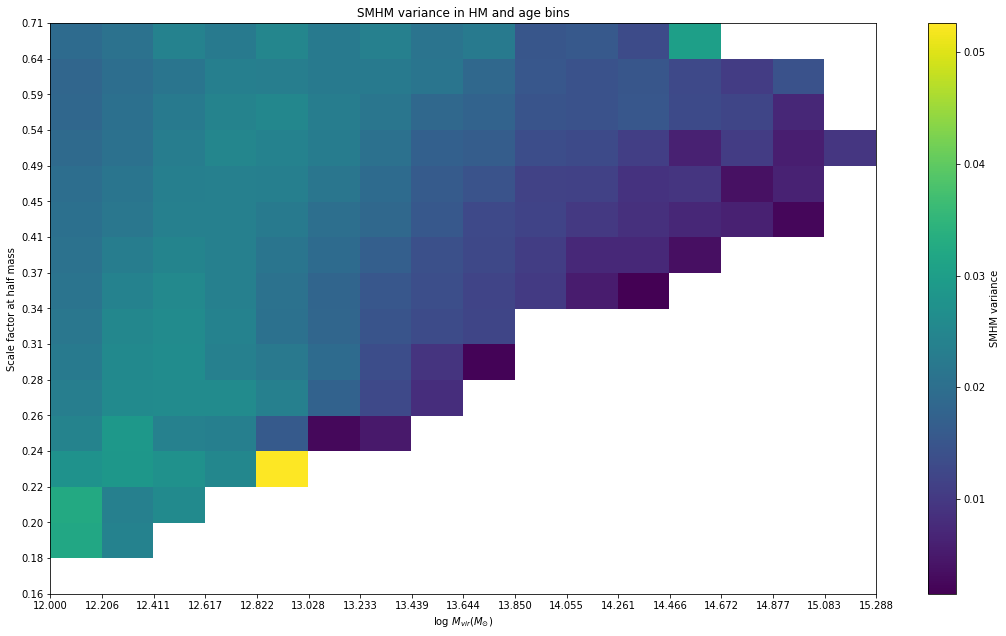

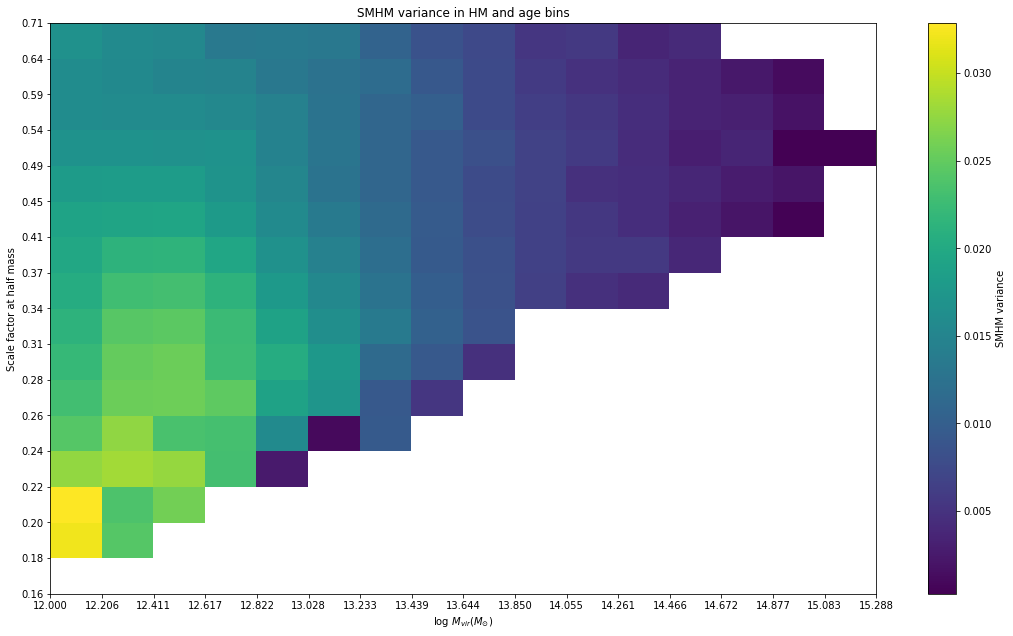

In [144]:
reload(plots)
print("Just centrals")
plots.age_vs_scatter(centrals)
print("All galacies")
plots.age_vs_scatter(data["all"])
# You are using halo age at the moment.
# I don't think we have the halfmass stellar age?

# Major Mergers

Just centrals
79
0.0511 0.7124
Total SM (including all sats)
79
0.0511 0.7124


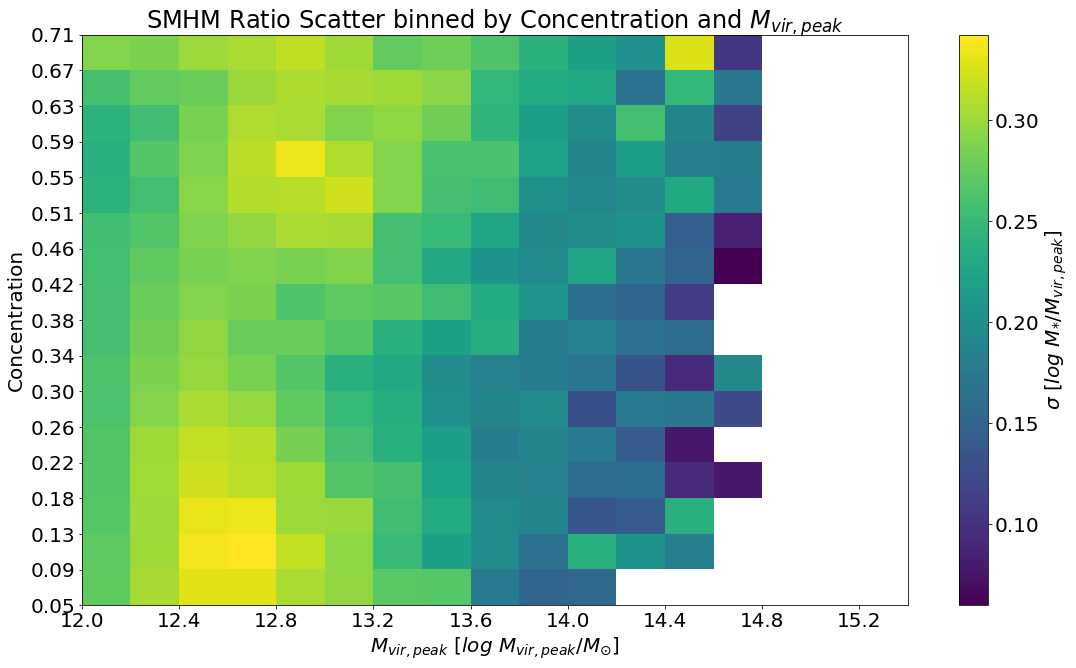

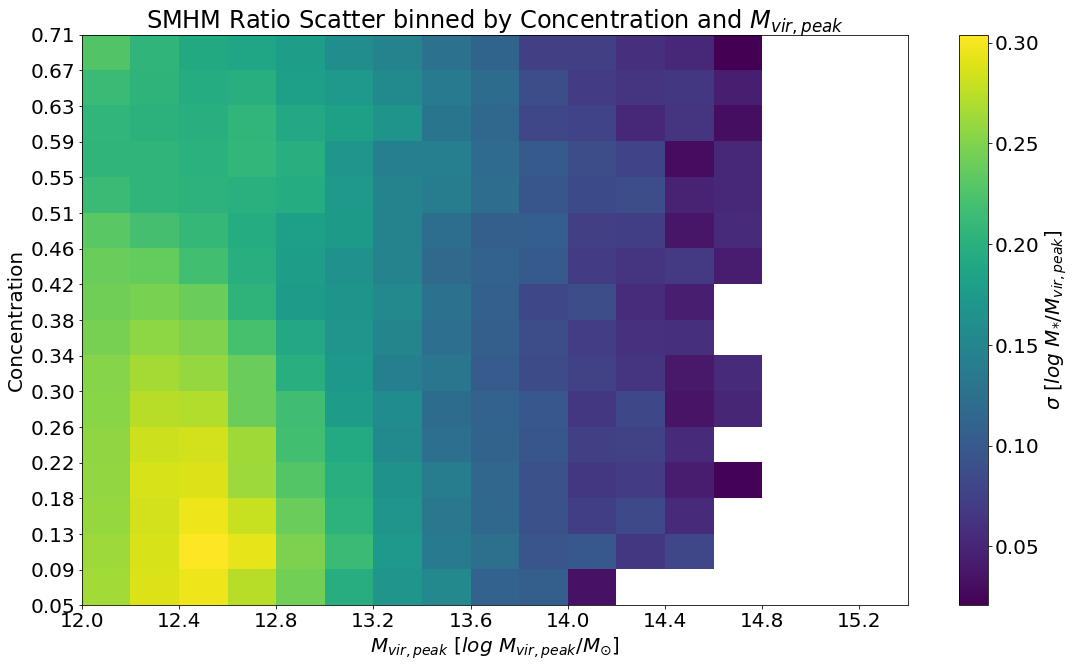

In [296]:
reload(plots)
# should probably have the centrals vs all in the title not just printed...
print("Just centrals")
plots.mm_vs_scatter(centrals)
print("Total SM (including all sats)")
plots.mm_vs_scatter(data["all"])